## 分析A/B测试结果

## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)


<a id='intro'></a>
### 简介

对于这个项目，我将要了解的是电子商务网站运行的 A/B 测试的结果。
我的目标是通过这个 notebook 来帮助公司弄清楚他们是否应该使用新的页面，保留旧的页面，或者应该将测试时间延长，之后再做出决定。



<a id='probability'></a>
#### I - 概率

让我们先导入库，然后开始你的任务吧。

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
df=pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


#### 理解数据集
##### User_id代表用户的id，timestamp表示记录的时间，group包含对照组和实验组。
##### Control是对照组，Treatment是实验组，
##### Converted由0和1表示，0表示转化失败，1表示转化成功。
##### Control group 对应的是old_page(旧页面),Treatment group 对应的是new_page(新页面)

In [3]:
df.group.unique(),df.landing_page.unique(),df.converted.unique()

(array(['control', 'treatment'], dtype=object),
 array(['old_page', 'new_page'], dtype=object),
 array([0, 1], dtype=int64))

In [4]:
df.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

In [5]:
#Convert timestamp from object type to datetime type.
df["timestamp"]=pd.to_datetime(df["timestamp"])

In [6]:
df.dtypes

user_id                  int64
timestamp       datetime64[ns]
group                   object
landing_page            object
converted                int64
dtype: object

In [7]:
#Duration for the A/B test
df.timestamp.max()-df.timestamp.min()

Timedelta('21 days 23:59:49.081927')

In [8]:
df.shape[0]

294478

In [9]:
df.user_id.nunique()

290584

In [10]:
#Total converted rate for both control group and treatment group.
df.converted.sum()/df.shape[0]

0.11965919355605512

In [11]:
#转换成布尔值，再对布尔值（隐性转换成整数）求和的方法
treatment = df['group'] == 'treatment'
new_page  = df['landing_page'] == 'new_page'
mismatch  = treatment != new_page
mismatch.sum()

3893

In [11]:
"""#Calculate mismatching time for new_page
new_page_mis=df.query("landing_page == 'new_page' & group !='treatment'").shape[0]
#Calculate mismatching time for old_page
old_page_mis=df.query("landing_page == 'old_page' & group !='control'").shape[0]
#Add numbers together
new_page_mis+old_page_mis"""

3893

In [12]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

In [12]:
# 使用 ~mismatch 排除 mismatch 的各行,再传入df2
df2 = df[~mismatch].copy()

In [13]:
"""#Create a new dataFrame named df2
#First assign matched new_page to dataFrame
df2=df[(df["landing_page"] == 'new_page') & (df["group"] =='treatment')]
#Then append matched old_page to dataFrame
df2=df2.append(df[(df["landing_page"] == 'old_page') & (df["group"] =='control')])"""

In [13]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [15]:
df2.shape[0]

290585

In [16]:
df2.user_id.nunique()

290584

In [17]:
df2.user_id.value_counts().head(1)

773192    2
Name: user_id, dtype: int64

In [18]:
df2.query("user_id == 773192")

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [19]:
#drop the duplicated row
df2.drop(index=2893,inplace=True)
#Check to see if it works
df2.query("user_id == 773192")

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


In [20]:
df2.converted.sum()/df2.shape[0]

0.11959708724499628

In [21]:
#Converted rate for control group
df2.query("group == 'control'").converted.sum()/df2.query("group == 'control'").shape[0]

0.1203863045004612

In [22]:
#Converted rate for treatment group
df2.query("group == 'treatment'").converted.sum()/df2.query("group == 'treatment'").shape[0]

0.11880806551510564

In [23]:
0.1203863045004612-0.11880806551510564

0.0015782389853555567

In [24]:
df2.query("landing_page == 'new_page'").shape[0]/df2.shape[0]

0.5000619442226688

In [25]:
df2.query("landing_page == 'old_page'").shape[0]/df2.shape[0]

0.4999380557773312

**1.control组的转化率是12.03%,treatment组的转化率是11.88%。我们没有足够的证据证明一个新页面可以带来更多的转化。**

<a id='ab_test'></a>
### II - A/B 测试

`1.` 根据提供的所有数据做出决定。**假定旧的页面效果更好**，除非新的页面在类型I错误率为5％的情况下才能证明效果更好，零假设和备择假设如下：

$$H_0:p_{new}-p_{old}≤0$$
$$H_1:p_{new}-p_{old}>0$$
$$\alpha = 5 \% $$

`2.` 假定在零假设中，不管是新页面还是旧页面， $p_{new}$ and $p_{old}$ 都具有等于 **转化** 成功率的“真”成功率，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，假设它们都等于**ab_data.csv** 中的 **转化** 率，新旧页面都是如此。  <br><br>

每个页面的样本大小要与 **ab_data.csv** 中的页面大小相同。  <br><br>

执行两次页面之间 **转化** 差异的抽样分布，计算零假设中10000次迭代计算的估计值。  <br><br>


a. 在零假设中，$p_{new}$ 的 **convert rate（转化率）** 是多少？

In [26]:
p_new = 0.11959708724499628

b. 在零假设中， $p_{old}$  的 **convert rate（转化率）** 是多少？ <br><br>

In [27]:
p_old = 0.11959708724499628

c.  $n_{new}$ 是多少？ 

In [28]:
n_new = df2.query("landing_page == 'new_page'").shape[0]
n_new

145310

d.  $n_{old}$?是多少？

In [29]:
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_old

145274

e. 在零假设中，使用 $p_{new}$ 转化率模拟 $n_{new}$ 交易，并将这些 $n_{new}$ 1's 与 0's 存储在 **new_page_converted** 中。

In [30]:
new_page_converted =  np.random.choice(a=[0,1],size=n_new,p=[1-p_new,p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. 在零假设中，使用 $p_{old}$ 转化率模拟 $n_{old}$ 交易，并将这些  $n_{old}$ 1's 与 0's 存储在 **old_page_converted** 中。

In [31]:
old_page_converted =  np.random.choice(a=[0,1],size=n_old,p=[1-p_old,p_old])
old_page_converted

array([0, 0, 0, ..., 0, 1, 0])

g. 在 (e) 与 (f)中找到 $p_{new}$ - $p_{old}$ 模拟值。

In [32]:
new_page_converted.mean() - old_page_converted.mean()

3.2663840737204297e-05

h. 使用**a. 到 g. ** 中的计算方法来模拟 10,000个 $p_{new}$ - $p_{old}$ 值，并将这 10,000 个值存储在 **p_diffs** 中。

In [35]:
p_diffs =[]
for _ in range(10000):
    new_page_converted =  np.random.choice(a=[0,1],size=n_new,p=[1-p_new,p_new])
    old_page_converted =  np.random.choice(a=[0,1],size=n_old,p=[1-p_old,p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. 绘制一个 **p_diffs** 直方图。

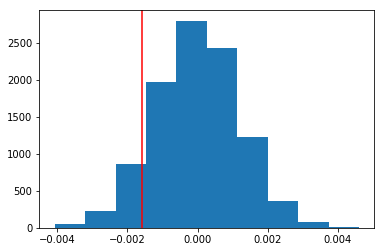

In [252]:
plt.hist(p_diffs);
#正态分布
plt.axvline(x=(0.11880806551510564-0.1203863045004612),color="red");

j.  在**p_diffs**列表的数值中，有多大比例大于 **ab_data.csv** 中观察到的实际差值？

In [253]:
(np.array(p_diffs) > (0.11880806551510564-0.1203863045004612) ).mean()

0.9042

**获得P值=0.9042，根据这个数值，我们没有证据拒绝零假设，因此，新旧页面的转化率存在有区别。**


l. 使用一个内置程序 （built-in）来实现类似的结果。

In [35]:
import statsmodels.api as sm

convert_old = df2.query(" landing_page == 'old_page'")["converted"].sum()
convert_new = df2.query(" landing_page == 'new_page'")["converted"].sum()

convert_old,n_old,convert_new,n_new

(17489, 145274, 17264, 145310)

m. 现在使用 `stats.proportions_ztest` 来计算你的检验统计量与 p-值。

In [36]:
z_score, p_value = sm.stats.proportions_ztest([17264,17489], [145310,145274],alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

**根据上题算出的 z-score 和 p-value，我们没有证据拒绝零假设，因此，新旧页面的转化率存在有区别。它们与 **j.** 与 **k.** 中的结果一致。**

<a id='regression'></a>
### III - 回归分析法之一

`1.` 之前的A / B测试中获得的结果也可以通过执行回归来获取。<br><br>

a. 既然每行的值是转化或不转化，那么在这种情况下，**我们应该执行逻辑回归。**

b. 目标是使用 **statsmodels** 来拟合回归模型，以查看用户收到的不同页面是否存在显著的转化差异。

首先，需要为这个截距创建一个列（ 原文：column） ，并为每个用户收到的页面创建一个虚拟变量列。添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。

In [37]:
#create a column for the intercept
df2["intercept"]=1

In [38]:
# create a dummy variable column for which page each user received.
df2[["new_page","old_page"]] = pd.get_dummies(df2["landing_page"])

In [39]:
#as well as an ab_page column, which is 1 when an individual receives the treatment and 0 if control.
df2[["control","ab_page"]] = pd.get_dummies(df2["group"])

In [40]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,control,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,0,1


c. 使用 **statsmodels** 导入你的回归模型。 实例化该模型，并使用创建的2个列来拟合该模型，用来预测一个用户是否会发生转化。

In [41]:
y = df2["converted"]
X = df2[["intercept","ab_page"]]
logit_mod = sm.Logit(y,X)
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. 模型摘要。

In [42]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-05-18 12:10 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

根据逻辑回归模型的结果，与ab_page关联的 p-value 是 0.1899。

在回归中，p值是用于检验截距或者斜率的参数(Coef.)是否等于0。并且，如果P值$>$显著性水平$\alpha$，则没有足够证据拒绝零假设，因此$\beta_1 = 0$,ab_page和响应变量之间没有统计显著性。

以下是逻辑回归中的零假设和备择假设：
$$H_0:\beta_1 = 0$$
$$H_1:\beta_1 ≠ 0$$
$$\alpha = 5 \% $$

相当于

$$H_0: P_{new}−P_{old} = 0$$
$$H_1: P_{new}−P_{old} ≠ 0$$

在**II**中，p_value= 0.90505831275902449。

在假设检验中，p值是如果零假设为真，观察到统计量 (或支持备择假设的更多极端) 的概率。

以下是**Part II** 中的零假设和备择假设：
$$H_0:p_{new}-p_{old}≤0$$
$$H_1:p_{new}-p_{old}>0$$
$$\alpha = 5 \% $$

**此两处假设的核心区别在于检验的 “方向性”：第 II 部分是 “单尾检验”，第 III 部分是 “双尾检验”。**



f.考虑其他可能影响用户是否发生转化的因素。讨论为什么考虑将其他因素添加到回归模型中是一个不错的主意。在回归模型中添加附加项有什么弊端吗？

<li>** 因为因变量的变化往往受几个重要因素的影响，此时就需要用两个或两个以上的影响因素作为自变量来解释因变量的变化。**
<li>** 我们希望自变量和因变量相关，但是我们不希望自变量彼此之间相关。如果我们的自变量彼此相关，在回归模型中添加附加项可能会出现多重共线性，导致系数偏离我们想要的方向。**

g. 现在，除了测试不同页面的转化率是否会发生变化之外，还要根据用户居住的国家或地区添加一个 effect 项。你需要导入 **countries.csv** 数据集，并将数据集合并在适当的行上。 [这里](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) 是链接表格的文档。 

这个国家项对转化有影响吗？不要忘记为这些国家的列创建虚拟变量—— **提示: 你将需要为这三个虚拟变量增加两列。** 提供统计输出，并书面回答这个问题。

In [43]:
#load the dataset and pass to df3
df3 = pd.read_csv("countries.csv")
# combine df2 with df3
df4 = df2.set_index('user_id').join(df3.set_index('user_id'))
df4.head()

,timestamp,group,landing_page,converted,intercept,new_page,old_page,control,ab_page,country
user_id,,,,,,,,,,
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1,US
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,0,1,CA
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,0,1,UK
839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,0,1,CA


In [44]:
df4.tail()

,timestamp,group,landing_page,converted,intercept,new_page,old_page,control,ab_page,country
user_id,,,,,,,,,,
718310,2017-01-21 22:44:20.378320,control,old_page,0,1,0,1,1,0,US
751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0,1,1,0,US
945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0,1,1,0,US
734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0,1,1,0,US
697314,2017-01-15 01:20:28.957438,control,old_page,0,1,0,1,1,0,US


In [45]:
#create dummy variables
df4[["CA","UK","US"]] = pd.get_dummies(df4["country"])

In [46]:
#add intercept
df4["intercept"] = 1
#create model
logit_mod = sm.Logit(df4["converted"],df4[["intercept","CA","UK"]])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [47]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-05-18 12:11 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

#### 回答：这个国家项对转化有影响吗？

根据逻辑回归模型的结果，CA对应的 p-value 是 0.1291，UK对应的 p-value 是 0.4558。

$12.91\%$ > $\alpha$，$45.58\%$ > $\alpha$，因此我们不拒绝零假设，CA没有显著性差异，UK没有显著性差异。

因此CA和UK与响应变量都没有统计显著性。我们没有足够的证据可以证明国家项对转化有影响。

h. 虽然你现在已经查看了国家与页面在转化率上的个体性因素，但现在我们要查看页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。创建必要的附加列，并拟合一个新的模型。  

提供你的摘要结果，以及根据结果得出的结论。

In [48]:
#创建交叉项
df4['new_CA'] = df4['new_page'] * df4['CA']
df4['new_UK'] = df4['new_page'] * df4['UK']

In [49]:
#add intercept
df4["intercept"] = 1
#create model
logit_mod = sm.Logit(df4["converted"],df4[["intercept","new_page","CA","UK","new_CA","new_UK"]])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [50]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-05-18 12:11 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
new_page     -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
new_CA       -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
new_UK        0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

#### 回答：

根据逻辑回归模型的结果，new_CA对应的 p-value 是 0.3833，new_UK对应的 p-value 是 0.2377。

$38.33\%$ > $\alpha$，$23.77\%$ > $\alpha$，因此我们不拒绝零假设，new_CA没有显著性差异，new_UK没有显著性差异。

因此new_CA和new_UK与响应变量都没有统计显著性。我们没有足够的证据可以证明交叉项对转化有影响。